In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from pathlib import Path
import sys
import glob
import yaml
from yaml.loader import SafeLoader
from os.path import join
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio 
import rasterio.plot
import rasterio.mask
import json
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
import matplotlib.colors as mpc
from matplotlib import colormaps, cm
from matplotlib.collections import PatchCollection
from pandas.plotting import parallel_coordinates

import unsafe.files as unfile

# Configure

In [ ]:
# Specify FIPS, etc., 
fips_args = {
    'FIPS': ['34007'], 
    'STATEFIPS': ['34'],
    'STATEABBR': ['NJ'],
    'NATION': ['US']
}
FIPS = fips_args['FIPS'][0]
NATION = fips_args['NATION'][0]
STATEABBR = fips_args['STATEABBR'][0]
STATEFIPS = fips_args['STATEFIPS'][0]

In [ ]:
# Read in the config file and set up key parameters
ABS_DIR = Path().absolute().parents[1]

CONFIG_FILEP = join(ABS_DIR, 'config', 'config.yaml')
# Open the config file and load
with open(CONFIG_FILEP) as f:
    CONFIG = yaml.load(f, Loader=SafeLoader)

# Number of states of the world
N_SOW = CONFIG['sows']

# Hazard scenarios
SCENARIOS = CONFIG['scenarios']

In [ ]:
# Quick references to directories
FR = join(ABS_DIR, "data", "raw")

# And external - where our hazard data should be
FE = join(FR, "external")

# Set up interim and results directories as well
# We already use "FR" for raw, we use "FO" 
# because you can also think of results
# as output
FI = join(ABS_DIR, "data", "interim")
FO = join(ABS_DIR, "data", "results")

# "Raw" data directories for exposure, vulnerability (vuln) and
# administrative reference files
EXP_DIR_R = join(FR, "exp")
VULN_DIR_R = join(FR, "vuln")
REF_DIR_R = join(FR, "ref")
# Haz is for depth grids
HAZ_DIR_R = join(FE, "haz")
# Pol is for NFHL
POL_DIR_R = join(FR, "pol")

# Unzip directory 
UNZIP_DIR = join(FR, "unzipped")

# We want to process unzipped data and move it
# to the interim directory where we keep
# processed data
# Get the filepaths for unzipped data
# We unzipped the depth grids (haz) and 
# ddfs (vuln) into the "external"/ subdirectory
HAZ_DIR_UZ = join(UNZIP_DIR, "external", "haz")
POL_DIR_UZ = join(UNZIP_DIR, "pol")
REF_DIR_UZ = join(UNZIP_DIR, "ref")
VULN_DIR_UZ = join(UNZIP_DIR, "vuln")
DDF_DIR_UZ = join(UNZIP_DIR, "external", "vuln")

# "Interim" data directories
EXP_DIR_I = join(FI, "exp")
VULN_DIR_I = join(FI, "vuln")
REF_DIR_I = join(FI, "ref")
# Haz is for depth grids
HAZ_DIR_I = join(FI, "haz")
# Pol is for NFHL
POL_DIR_I = join(FI, "pol")

# Figures directory
FIG_DIR = join(ABS_DIR, "figures")

# Load and prepare data

In [ ]:
# Load geospatial data
clip_geo = gpd.read_file(join(REF_DIR_I, FIPS, "clip.gpkg"))
tract_geo = gpd.read_file(join(REF_DIR_I, FIPS, "tract.gpkg"))
bg_geo = gpd.read_file(join(REF_DIR_I, FIPS, "bg.gpkg"))
nsi_geo = gpd.read_file(join(EXP_DIR_I, FIPS, "nsi_sf.gpkg"))

# including vulnerability data
lmi = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'lmi.gpkg'))
ovb = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'ovb.gpkg'))
cejst = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'cejst.gpkg'))
sovi = gpd.read_file(join(VULN_DIR_I, 'social', FIPS, 'sovi.gpkg'))
# and the indicators dataframe to subset for maps
c_ind = pd.read_parquet(join(VULN_DIR_I, 'social', FIPS, 'c_indicators.pqt'))

In [ ]:

# Read in check_structures_final.csv and filter
# For those that don't, load back the fd_id that are not residential structures
# Filter these out in the dataframes before generating results
check_filepath = join(ABS_DIR, "data", "check", "check_structures_final.csv")
check_df = pd.read_csv(check_filepath)
drop_ids = check_df[check_df['is_house'] != True]['fd_id']

# The ensemble w/ opt heightenings & associated values
# We will do some plots based on the expected value of some
# metrics across SOWs
# Load the ensemble data, along with the optimal
# elevation results
ens_agg_dfs = {}

elev_ids = {}
objs_dfs = []

for scen in SCENARIOS:
    ens_filep = join(FO, 'ensemble_' + scen + '.pqt')
    ens_df = pd.read_parquet(ens_filep)
    print('Load data: ' + scen)
    
    obj_filep = join(FO, 'pol_obj_vals_' + scen + '.pqt')
    objs_dfs.append(pd.read_parquet(obj_filep))

    elev_ids_filep = join(FO, 'pol_elev_ids_' + scen + '.json')
    with open(elev_ids_filep, 'r') as fp:
        elev_ids_temp = json.load(fp)
    elev_ids = elev_ids | elev_ids_temp

    opt_elev_filename = 'ens_opt_elev_' + scen + '.pqt'
    opt_elev_df = pd.read_parquet(join(EXP_DIR_I, FIPS, opt_elev_filename))
    print('Load opt elev')

    # Merge on fd_id and sow_ind to get eal_avoid, elev_cost, and opt_elev
    # into the ensemble
    ens_df_m = ens_df.merge(opt_elev_df,
                            on=['fd_id', 'sow_ind'],
                            suffixes=['','_opt'])

    # Get ens_agg for rel_eal, resid_rel_eal, & val_s metrics
    eal_col = 'eal'
    ens_df_m['rel_eal'] = ens_df_m[eal_col]/ens_df_m['val_s']
    ens_df_m['npv_opt'] = ens_df_m['pv_avoid'] - ens_df_m['pv_cost']
    ens_df_m['elev_ft'] = ens_df_m['opt_elev'].astype(int)
    ens_agg = ens_df_m.groupby('fd_id')[['rel_eal',
                                            'npv_opt',
                                            'pv_resid',
                                            'elev_invst',
                                            'resid_rel_eal',
                                            'elev_ft',
                                            'val_s']].mean().reset_index()
    
    ens_agg_max = ens_df_m.groupby('fd_id')[['rel_eal']].max().reset_index()
    
    ens_agg = ens_agg[~ens_agg['fd_id'].isin(drop_ids)]

    ens_agg = ens_agg.merge(ens_agg_max, on='fd_id',
                            suffixes=['', '_max'])

    # We need to merge ens_agg with nsi_geo 
    ens_agg_plot = nsi_geo.merge(ens_agg,
                                    how='inner',
                                    on='fd_id')

    ens_agg_dfs[scen] = ens_agg_plot

    print('Store gdf of aggregated values\n')

objs = pd.concat(objs_dfs, axis=0)

In [ ]:
# Subset sovi and lmi based on their threshholds
sovi = sovi[sovi['sovi'] > .6]
lmi = lmi[lmi['Lowmod_pct'] > .5]
ovb = ovb[ovb['ovb_crit'] != 'Adjacent']

# Main Figures

## Figure 2

In [ ]:
for scen in SCENARIOS: 
    comm_list = [cejst, lmi, sovi, ovb]

    # Colormaps for eal_base 
    # Trying 'sunset' from Paul Tol
    # https://cran.r-project.org/web/packages/khroma/
    # vignettes/tol.html#diverging-data
    cmap_eal_l = ['#FEDA8B', '#FDB366',
                '#F67E4B', '#DD3D2D', '#A50026']
    cmap_eal = mpc.LinearSegmentedColormap.from_list("", cmap_eal_l)


    comm_titles = {
        'lmi': 'FHA Low-Moderate Income',
        'sovi': 'CDC Socially Vulnerable' ,
        'cejst': 'Justice40 Community',
        'ovb': 'NJ Overburdened'
    }

    comm_names = ['cejst', 'lmi', 'sovi', 'ovb']

    risk_cmap = cmap_eal
    tracts = tract_geo
    bgs = bg_geo

    ens_plot = ens_agg_dfs[scen]

    fig, ax = plt.subplots(
            figsize=(7, 6),
            nrows=2,
            ncols=2,
            dpi=600,
            gridspec_kw={"wspace": 0.01, "hspace": 0.22},
        )

    # Get rel_eal_pct column for plotting
    ens_plot["rel_eal_plot"] = np.round(ens_plot["rel_eal"] * 100)

    # Try reprojecting everything to epsg=3857
    tracts = tracts.to_crs(epsg=3857)
    bgs = bgs.to_crs(epsg=3857)
    ens_plot = ens_plot.to_crs(epsg=3857)

    # Helps to zoom in on places where at-risk homes are
    total_bounds = ens_plot.geometry.total_bounds
    buffer = 750
    minx = total_bounds[0] - buffer
    maxx = total_bounds[2] + buffer
    miny = total_bounds[1] - buffer 
    maxy = total_bounds[3] + buffer
    bounds = [minx, miny, maxx, maxy]
    if scen == 'Upper':
        bounds = None

    # Loop through each layer
    for i, comm_geo in enumerate(comm_list):
        row = i % 2
        col = i // 2

        # Reproject layer to tract crs
        comm_plot = comm_geo.to_crs(epsg=3857)

        # Layer name
        name_l = comm_names[i]

        # Plot the layer boundary in each column
        comm_plot.plot(ax=ax[row, col], color="#18437f", alpha=0.75, edgecolor="white", lw=1)

        # Plot census tract boundaries in top row
        # and block group in bottom
        if row == 0:
            tracts.plot(ax=ax[row, col], edgecolor="white", color="none", lw=1)
        else:
            bgs.plot(ax=ax[row, col], edgecolor="white", color="none", lw=1)

        # Caption the subplot title
        ax[row, col].set_title(comm_titles[name_l], size=12)

        # Plot the eal
        vmin_eal = 0
        vmax_eal = ens_plot["rel_eal_plot"].max()
        # Sort before plotting
        ens_plot = ens_plot.sort_values("rel_eal_plot", ascending=True)
        ens_plot.plot(
            ax=ax[row, col],
            column="rel_eal_plot",
            cmap=risk_cmap,
            s=1,
            vmin=vmin_eal,
            vmax=vmax_eal,
        )

        cx.add_basemap(ax[row, col],
                    attribution_size=4,
                    source=cx.providers.Esri.WorldImagery)

        # Set axis off but keep outline
        ax[row, col].tick_params(
            axis="both",
            which="both",
            bottom=False,
            left=False,
            labelbottom=False,
            labelleft=False,
        )

        # Zoom in on points
        if bounds is not None:
            minx = bounds[0]
            miny = bounds[1]
            maxx = bounds[2]
            maxy = bounds[3]
            ax[row, col].set_xlim([minx, maxx])
            ax[row, col].set_ylim([miny, maxy])

        # Display a legend, just to make it clear
        # which areas are "disadvantaged"
        legend_elements = [
            Patch(facecolor="#18437f", 
                alpha=0.75, label="Disadvantaged\nCommunity")
        ]

        ax[row, col].legend(
            handles=legend_elements,
            loc="center",
            fontsize="small",
            bbox_to_anchor=(0.72, 0.91),
            #frameon=False,
        )

    # Add continuous legends
    cax = fig.add_axes([0.21, 0.06, 0.61, 0.02])
    sm = plt.cm.ScalarMappable(
        cmap=risk_cmap, norm=plt.Normalize(vmin=vmin_eal, vmax=vmax_eal)
    )
    sm._A = []
    cbr = fig.colorbar(
        sm,
        cax=cax,
        orientation="horizontal",
        format=ticker.PercentFormatter(decimals=0),
    )
    cbr.ax.tick_params(labelsize=12)
    cbr.set_label("Risk Burden (%)", size=12)

    save_filename = join(FIG_DIR, 'Figure2',
                        scen + '.png')
    unfile.prepare_saving(save_filename)
    fig.savefig(save_filename, bbox_inches='tight', dpi=600)

## Figure 3

In [ ]:
scen = 'Upper'
ens_plot = ens_agg_dfs[scen]

budget = 1e6

title_dict = {
    'lmi': 'Rule: Majority of Benefits in\nLow-Mod Income Block Groups',
    'npv_opt': 'Rule: Highest to Lowest\nNet Benefit' ,
    'sovi': 'Rule: Majority of Benefits in\nCDC Socially Vulnerable',
    'rel_eal': 'Rule: Highest to Lowest\nInitial Risk Burden',
    'cejst': 'Rule: Majority of Benefits in\nJustice40 Communities',
    'avoid_rel_eal': 'Rule: Highest to Lowest\nReduction in Risk Burden'
}

sort_cols = ['npv_opt',
             'cejst', 
             'rel_eal',
             'sovi',
             'avoid_rel_eal',
             'lmi']

color_dict = {
    'sovi': "#33BBEE",
    'lmi': "#0077BB",
    'cejst': "#009988",
    'avoid_rel_eal': "#EE3377",
    'rel_eal': "#CC3311",
    'npv_opt': "#EE7733",
}

fig, ax = plt.subplots(
        figsize=(8, 10),
        nrows=3,
        ncols=2,
        dpi=600,
        sharey=True,
        sharex=True,
        gridspec_kw={"wspace": 0.15, "hspace": 0.35},
    )

# Some preprocessing to help the plotting look nicer
# get structural value in thousands
ens_plot["val_s_thou"] = ens_plot["val_s"] / 1e3
# get the rel_eal_plot columns
ens_plot["rel_eal_plot"] = np.round(ens_plot["rel_eal"] * 100)
ens_plot["resid_rel_eal_plot"] = np.round(ens_plot["resid_rel_eal"] * 100)

for i, sort in enumerate(sort_cols):
    col = i % 2
    row = i // 2

    # Find the policy
    policy = sort + "_" + str(budget)
    fd_ids = elev_ids[scen + "_" + policy]

    # Subset into homes that are elevated for this policy
    elevated = ens_plot.loc[ens_plot["fd_id"].isin(fd_ids)]
    not_elev = ens_plot.loc[~ens_plot["fd_id"].isin(fd_ids)]

    # Plot a vertical line that goes through the highest
    # remaining risk burden
    ax[row, col].axhline(not_elev['rel_eal_plot'].max(),
                         color='red',
                         lw=2,
                         alpha=1,
                         zorder=0,
                         ls='--')

    # Plot the initial risk burden plot
    # We'll use the size/2 so that the points
    # which aren't elevated don't show as prominently
    # We'll also plot them first so that they are below the
    # elevated points
    not_elev.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        edgecolor="gray",
        color="white",
        label="Not Elevated",
        s=15 / 2,
        ax=ax[row, col],
    )
    # We'll plot these in the green #225522 so they stand out
    elevated.plot(
        x="val_s_thou",
        y="rel_eal_plot",
        kind="scatter",
        color="#225522",
        label="Elevated",
        s=25,
        ax=ax[row, col],
    )
    # Add title
    ax[row, col].set_title(title_dict[sort], size=12)

    # Clean up the plot
    # Remove left ticks from each axis in column 1
    # ax[row, 1].tick_params(axis='both',
    #                        which='both',
    #                        left=False)
    # Remove bottom ticks from each axis in row 1
    ax[0, col].tick_params(axis="both", which="both")
    ax[row, 0].set_ylabel("Initial Risk Burden (%)", size=12)
    ax[row, 0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax[2, col].set_xlabel("Initial Structure Value ($1,000s)", size=12)

ax[0, 1].get_legend().remove()
ax[1, 1].get_legend().remove()
ax[1, 0].get_legend().remove()
ax[2, 1].get_legend().remove()
ax[2, 0].get_legend().remove()

# Annotate top left plot
ax[0, 0].annotate("Highest\nremaining\nrisk burden", 
                  xy=(118, 33), xytext=(118, 33),
                  color="red",
                  ha="center",
                  )

# Update labels
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend(handles[::-1], labels[::-1], ncols=1)

# save_filename = join(FIG_DIR, 'Figure3',
#                      scen + '_budget_' +
#                      str(budget)[0] + 'e6_.png')
# unfile.prepare_saving(save_filename)
# fig.savefig(save_filename)

## Figure 4

In [10]:
# Calculating risk-burden inequality
def risk_val_gini(risk, val):
    risk = np.asarray(risk)
    val = np.asarray(val)
    # Sort both by ascending value index
    # and store the cumulative sum
    sorted_indices = np.argsort(val)
    sorted_risk = risk[sorted_indices].cumsum()
    population = np.arange(0, len(risk) + 1)/len(risk)
    # Normalize risk
    risk_norm = sorted_risk/sorted_risk.max()
    # Insert 0 for each
    risk_norm = np.insert(0., 1, risk_norm)
    # Calculate gini
    gini = np.abs((np.diff(population))*((risk_norm + np.roll(risk_norm, shift=1))[1:]/2) -
                  (np.diff(population)*(population + np.roll(population, shift=1))[1:]/2)).sum()/.5
    return gini

In [11]:
objs['policy'] = objs['scen_policy'].str.split('_').str[1:].apply(lambda x: '_'.join(x))
objs['scen'] = objs['scen_policy'].str.split('_').str[:1].apply(lambda x: '_'.join(x))
objs['sort'] = objs['policy'].str.split('_').str[:-1].apply(lambda x: '_'.join(x))
objs['budget'] = objs['policy'].str.split('_').str[-1].astype(float).astype(int)

/tmp/ipykernel_3477495/1726719068.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objs_plot["Funding Rule"] = objs_plot['sort'].map(sort_dict)
/tmp/ipykernel_3477495/1726719068.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objs_plot["order"] = objs_plot['sort'].map(order_dict)
/tmp/ipykernel_3477495/1726719068.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded fro

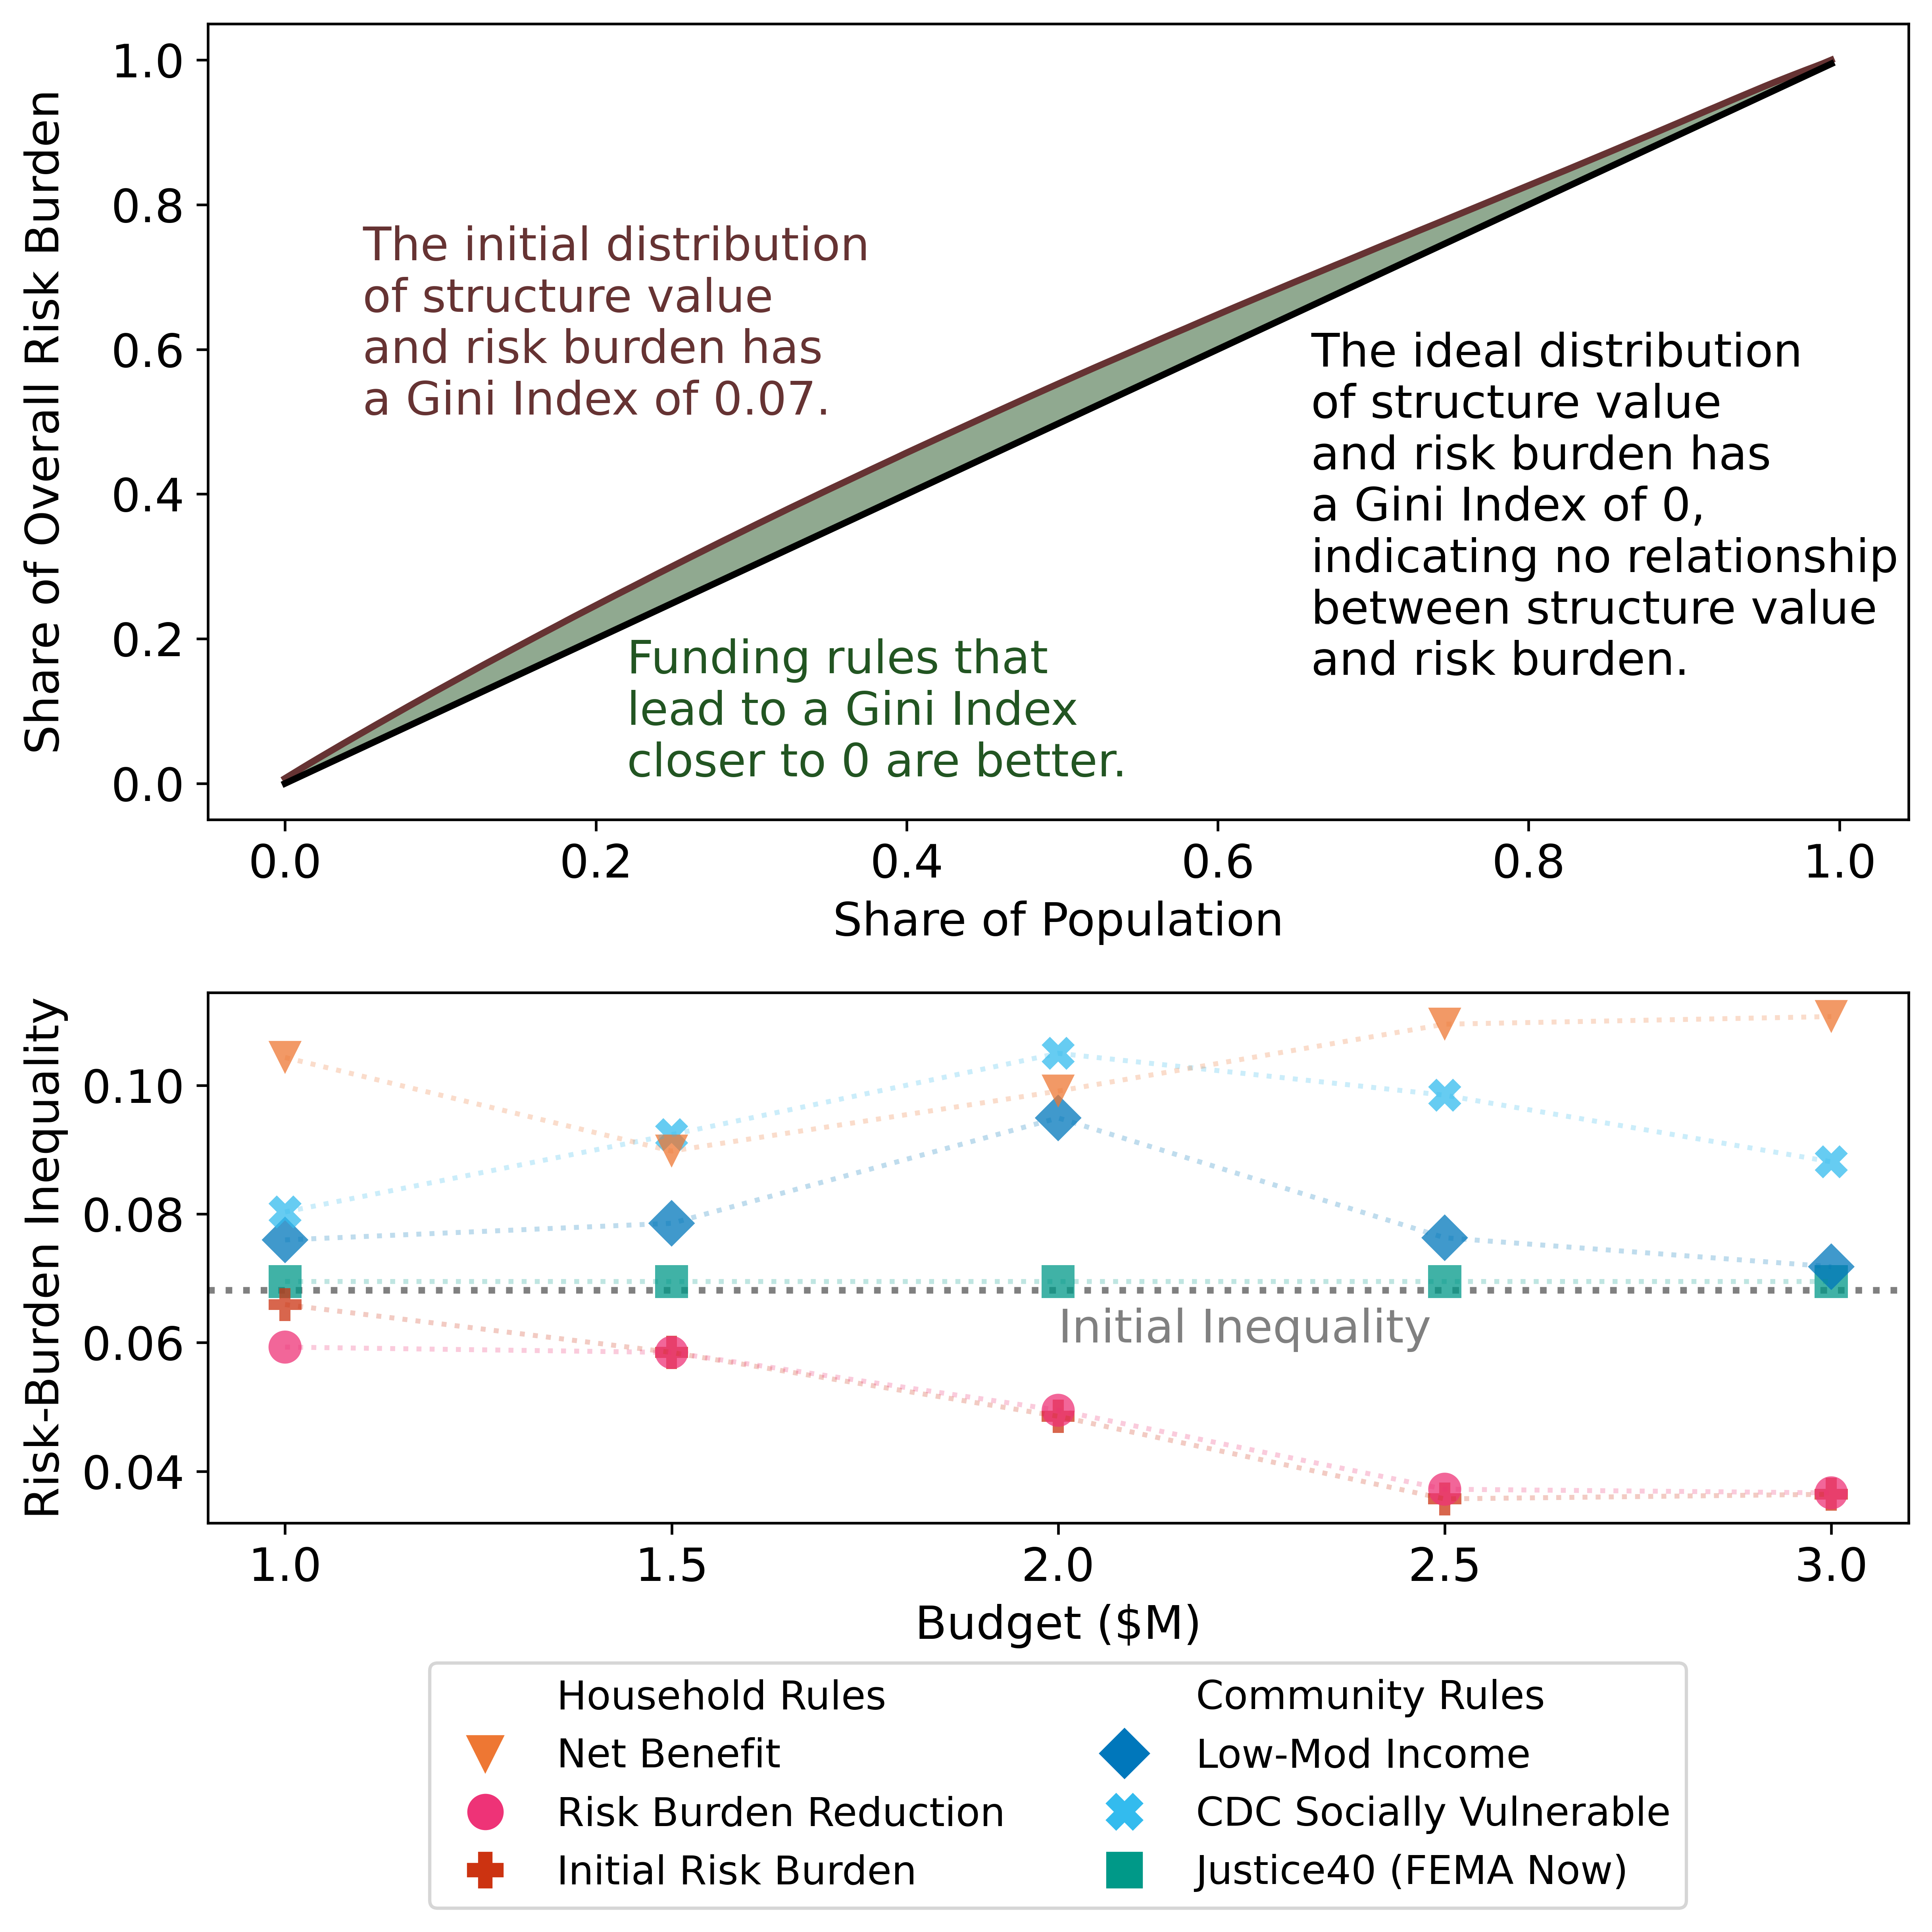

In [12]:
scen = 'Mid'
ens_filep = join(FO, 'ensemble_' + scen + '.pqt')
ens_df = pd.read_parquet(ens_filep)
eal_col = 'eal'
ens_df['rel_eal'] = ens_df[eal_col]/ens_df['val_s']

ens_df = ens_df[~ens_df['fd_id'].isin(drop_ids)]

ens_plot = ens_agg_dfs[scen]
objs_plot = objs[(objs['sort'] != 'ovb') &
                 (objs['budget'] <= 3e6) &
                 (objs['scen'] == scen)]

sort_cols = ['npv_opt',
             'cejst', 
             'lmi',
             'sovi',
             'rel_eal',
             'avoid_rel_eal']

color_dict = {
    'CDC Socially Vulnerable': "#33BBEE",
    'Low-Mod Income': "#0077BB",
    'Justice40 (FEMA Now)': "#009988",
    'Risk Burden Reduction': "#EE3377",
    'Initial Risk Burden': "#CC3311",
    'Net Benefit': "#EE7733",
}

sort_dict = {
    'cejst': 'Justice40 (FEMA Now)',
    'lmi': 'Low-Mod Income',
    'sovi': 'CDC Socially Vulnerable',
    'npv_opt': 'Net Benefit',
    'rel_eal': 'Initial Risk Burden',
    'avoid_rel_eal': 'Risk Burden Reduction'
}

order_dict = {
    'cejst': 0,
    'lmi': 1,
    'sovi': 2,
    'npv_opt': 3,
    'rel_eal': 4,
    'avoid_rel_eal': 5
}

markers_dict = {
    'CDC Socially Vulnerable': "X",
    'Low-Mod Income': "D",
    'Justice40 (FEMA Now)': "s",
    'Risk Burden Reduction': "o",
    'Initial Risk Burden': "P",
    'Net Benefit': "v",
}

# Prep plot colums
objs_plot["Funding Rule"] = objs_plot['sort'].map(sort_dict)
objs_plot["order"] = objs_plot['sort'].map(order_dict)
objs_plot = objs_plot.sort_values(['order', 'budget'])

# Plot the initial inequality 
# Lorenz using the mean values
ens_agg_gini = ens_df.sort_values(by=['sow_ind', 'val_s'], ascending=True)
ens_agg_gini['rel_eal_c'] = ens_agg_gini.groupby('sow_ind')['rel_eal'].cumsum()
ens_agg_gini['initial_sum'] = ens_agg_gini.groupby('sow_ind')['rel_eal_c'].transform(lambda x: x.max())
ens_agg_gini['initial_share'] = ens_agg_gini['rel_eal_c']/ens_agg_gini['initial_sum']
ens_agg_gini['population'] = ens_agg_gini.groupby('sow_ind').cumcount()
# Get the average initial_share values for each structure
ens_agg_gini = ens_agg_gini.groupby('population')['initial_share'].mean().reset_index()
# Get the population index
population = np.arange(0, len(ens_agg_gini))/len(ens_agg_gini)

# Gini using expected value from ensemble
gini_init = ens_df.groupby('sow_ind').apply(lambda x: risk_val_gini(x['rel_eal'],
                                                                    x['val_s'])).mean()
gini_plot = str(np.round(gini_init, 2))
    
# Now plot a big panel building intuition 
# about the Lorenz curve
# and the gini index
from matplotlib.gridspec import GridSpec
fig = plt.figure(layout="constrained",
                 figsize=(8, 8),
                 dpi=600)
gs = GridSpec(2, 1, figure=fig,
              height_ratios=[3, 2],
              hspace=.05)
ax1 = fig.add_subplot(gs[0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1])

ax1.plot(population,
         ens_agg_gini['initial_share'],
              color='#663333',
              lw=2,
              ls='-')
ax1.plot(population,
         population,
        lw=2,
        color='black')

ax1.fill_between(population,
                ens_agg_gini['initial_share'],
                population,
               color='#225522',
               alpha=.5)

ax1.set_xlabel("Share of Population",
              size=14)
ax1.set_ylabel("Share of Overall Risk Burden",
              size=14)
ax1.tick_params(axis="both", which="both", labelsize=14)

ax1.annotate('The initial distribution\nof structure value\nand risk burden has\na Gini Index of ' + gini_plot + '.',
            xy=(.05, .51), xytext=(.05, .51),
            color='#663333',
            size=14)

ax1.annotate('The ideal distribution\nof structure value\nand risk burden has\na Gini Index of 0,\nindicating no relationship\nbetween structure value\nand risk burden.',
            xy=(.66, .15), xytext=(.66, .15),
            color='black',
            size=14)

ax1.annotate('Funding rules that\nlead to a Gini Index\ncloser to 0 are better.',
            xy=(.22, .01), xytext=(.22, .01),
            color='#225522',
            size=14)

# Plot budgets and ginis
objs_plot['cost'] = objs_plot['up_cost']/1e6
objs_plot['budg_plot'] = objs_plot['budget']/1e6
ax2.axhline(gini_init, color='gray', lw=2, ls='dotted',
            zorder=0)

sns.lineplot(
    y='resid_eq',
    x='budg_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    legend=False,
    ls='dotted',
    alpha=.25,
    ax=ax2,
)

sns.scatterplot(x="budg_plot",
            y='resid_eq',
            data=objs_plot,
            hue="Funding Rule",
            palette=color_dict,
            style="Funding Rule",
            alpha=.75,
            markers=markers_dict,
            lw=0,
            edgecolor='none',
            s=100,
            legend=False,
            ax=ax2,)

ax2.set_xticks([1, 1.5, 2, 2.5, 3])
ax2.tick_params(labelsize=14)
ax2.set_ylabel('Risk-Burden Inequality', size=14)
ax2.set_xlabel('Budget ($M)', size=14)

# Add legend below
lw=2
legend_elements = [
        Line2D([0], [0], color="black", ls="none", label="Household Rules"),
        Line2D([0], [0], color=color_dict["Net Benefit"],
               marker=markers_dict["Net Benefit"],
               markersize=10,
               ls='none',
               lw=lw, label="Net Benefit"),
        Line2D(
            [0],
            [0],
            color=color_dict["Risk Burden Reduction"],
            marker=markers_dict["Risk Burden Reduction"],
            markersize=10,
            lw=lw,
            ls='none',
            label="Risk Burden Reduction",
        ),
        Line2D(
            [0], [0], color=color_dict["Initial Risk Burden"],
            marker=markers_dict["Initial Risk Burden"],
            markersize=10,
            ls='none',
            lw=lw, label="Initial Risk Burden"
        ),
        Line2D([0], [0], color="black", ls="none", label="Community Rules"),
        Line2D(
            [0],
            [0],
            color=color_dict["Low-Mod Income"],
            marker=markers_dict["Low-Mod Income"],
            markersize=10,
            lw=lw,
            ls="none",
            label="Low-Mod Income",
        ),
        Line2D(
            [0],
            [0],
            color=color_dict["CDC Socially Vulnerable"],
            marker=markers_dict["CDC Socially Vulnerable"],
            markersize=10,
            lw=lw,
            ls="none",
            label="CDC Socially Vulnerable",
        ),
        Line2D(
            [0],
            [0],
            color=color_dict["Justice40 (FEMA Now)"],
            label="Justice40 (FEMA Now)",
            marker=markers_dict["Justice40 (FEMA Now)"],
            markersize=10,
            ls="none",
        ),
    ]

ax2.legend(
        handles=legend_elements,
        loc="center",
        ncol=2,
        fontsize="large",
        bbox_to_anchor=(.5, -0.495),
    )

ax2.annotate('Initial Inequality', 
             size=14,
             xy=(2, .06), xytext=(2, .06),
             color='gray')

fig.align_ylabels()

save_filename = join(FIG_DIR, 'Figure4',
                             scen + '.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename)

## Figure 5

In [ ]:
scen = 'Mid'

color_dict = {
    'CDC Socially Vulnerable': "#33BBEE",
    'Low-Mod Income': "#0077BB",
    'Justice40 (FEMA Now)': "#009988",
    'Risk Burden Reduction': "#EE3377",
    'Initial Risk Burden': "#CC3311",
    'Net Benefit': "#EE7733",
}

sort_dict = {
    'cejst': 'Justice40 (FEMA Now)',
    'lmi': 'Low-Mod Income',
    'sovi': 'CDC Socially Vulnerable',
    'npv_opt': 'Net Benefit',
    'rel_eal': 'Initial Risk Burden',
    'avoid_rel_eal': 'Risk Burden Reduction'
}

order_dict = {
    'cejst': 0,
    'lmi': 1,
    'sovi': 2,
    'npv_opt': 3,
    'rel_eal': 4,
    'avoid_rel_eal': 5
}

markers_dict = {
    'CDC Socially Vulnerable': "X",
    'Low-Mod Income': "D",
    'Justice40 (FEMA Now)': "s",
    'Risk Burden Reduction': "o",
    'Initial Risk Burden': "P",
    'Net Benefit': "v",
}

objs_plot = objs[(objs['sort'] != 'ovb') &
                 (objs['scen'] == scen) &
                 (objs['budget'] <= 3e6)]

# Prep plot colums
objs_plot["npv_plot"] = objs_plot["npv"] / 1e6
objs_plot["avoid_eq1_plot"] = objs_plot["avoid_eq1"] * 100
objs_plot["Upfront Cost ($M)"] = objs_plot["up_cost"]/1e6
objs_plot["Budget ($M)"] = objs_plot['budget']/1e6
objs_plot["Funding Rule"] = objs_plot['sort'].map(sort_dict)
objs_plot["order"] = objs_plot['sort'].map(order_dict)
objs_plot = objs_plot.sort_values(['order', 'budget'])

fig, ax = plt.subplots(figsize=(6, 6), nrows=2,
                       gridspec_kw={'hspace': .03},
                       sharex=True,
                       dpi=600)

# Loop through each value in 'sort'
# Plot the kde
# Solid lines community, dashed for household
# Unique colors
lw = 2

# Plot boxplots for each policy besides Justice40
sns.lineplot(
    y='avoid_eq1_plot',
    x='npv_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    legend=False,
    alpha=.25,
    ls='dotted',
    ax=ax[0],
)

sns.scatterplot(
    y='avoid_eq1_plot',
    x='npv_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    style="Funding Rule",
    size="Budget ($M)",
    sizes=(50, 200),
    alpha=.75,
    markers=markers_dict,
    edgecolor='none',
    legend=True,
    ax=ax[0],
)

sns.lineplot(
    y='resid_eq',
    x='npv_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    legend=False,
    alpha=.25,
    ls='dotted',
    ax=ax[1],
)

sns.scatterplot(
    y='resid_eq',
    x='npv_plot',
    data=objs_plot,
    hue="Funding Rule",
    palette=color_dict,
    # lw=lw,
    style="Funding Rule",
    size="Budget ($M)",
    sizes=(50, 200),
    alpha=.75,
    markers=markers_dict,
    edgecolor='none',
    legend=True,
    ax=ax[1],
)

ax[0].set_xlabel("Project Net Benefit ($M)", size=14)
ax[1].set_xlabel("Project Net Benefit ($M)", size=14)

# Set y label
ax[0].set_ylabel("Highest Remaining\nRisk Burden", size=14)
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
ax[1].set_ylabel("Risk-Burden\nInequality", size=14)

# These are minimize objectives, so reverse y-axis
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[1].set_ylim(ax[1].get_ylim()[::-1])

# Arrows for directions of improvement
ax[0].annotate(
    "Directions of\nImprovement",
    xy=(0.075, 0.25),
    xycoords="axes fraction",
    xytext=(0.075, 0.25),
    textcoords="axes fraction",
    fontsize=12,
    color="black",
    horizontalalignment="left",
    verticalalignment="center",
)
ax[0].annotate(
    "",
    xytext=(0.06, 0.15),
    xy=(0.06, 0.325),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="simple", color="black"),
)
ax[0].annotate(
    "",
    xytext=(0.0512, 0.155),
    xy=(0.15, 0.155),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="simple", color="black"),
)

ax[1].annotate(
    "Directions of\nImprovement",
    xy=(0.075, 0.115),
    xycoords="axes fraction",
    xytext=(0.075, 0.115),
    textcoords="axes fraction",
    fontsize=12,
    color="black",
    horizontalalignment="left",
    verticalalignment="center",
)

ax[1].annotate(
    "",
    xytext=(0.06, 0.015),
    xy=(0.06, 0.19),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="simple", color="black"),
)
ax[1].annotate(
    "",
    xytext=(0.0512, 0.02),
    xy=(0.15, 0.02),
    xycoords="axes fraction",
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="simple", color="black"),
)

ax[1].set_yticks([.12, .1, .08, .06, .04])

fig.tight_layout()

ax[1].legend(
    # handles=legend_elements,
    loc="center",
    ncol=2,
    fontsize="large",
    bbox_to_anchor=(.47, -0.65),
)
ax[0].legend_.remove()

fig.align_ylabels(ax[:])

save_filename = join(FIG_DIR, 'Figure5',
                             scen + '.png')
unfile.prepare_saving(save_filename)
fig.savefig(save_filename, bbox_inches='tight', dpi=600)

# Summary stats

In [ ]:
# Want to get adjustments for previous elevation projects
# Load in fema assistance/grants
hma_proj_filep = join(FR, 'pol', 'fema_assistance',
                      'HazardMitigationAssistanceProjects.json')

hma_proj = pd.read_json(hma_proj_filep)
hma_proj = pd.json_normalize(hma_proj['HazardMitigationAssistanceProjects'])


# Subset from hma_proj.projecType.unique() for
# elevation of private structures
# The entries are a bit messy and more sophisticated
# data preparation could get a better estimate of the budgets
# This is a good enough first pass for getting an idea
# of the distribution of budgets for these projects
proj_types = ['202.1: Elevation of Private Structures - Riverine',
              '202.2: Elevation of Private Structures - Coastal',
              ]
elev_proj = hma_proj[hma_proj['projectType'].isin(proj_types)]

# add a year column
# We'll use the dateApproved year for a best guess of 
# what year the cost estimates reflect
elev_proj['year'] = pd.to_datetime(elev_proj['dateApproved'],
                                   errors='coerce').dt.year

# Today price = historic_price * (2022 index / historic_index) 
upper_infl_filep = join(ABS_DIR, 'resources',
                        'construction_deflator_new_sfh.xls')

# Read in the construction deflator for single family homes
upper_infl_filep = join(ABS_DIR, 'resources',
                        'construction_deflator_new_sfh.xls')
upper_infl = pd.read_excel(upper_infl_filep, header=4)

# We will groupby on year for the average Laspeyres (Fixed) index
# Then we will create the historic/2022 index values
upper_infl['year'] = upper_infl['Date'].dt.year
# Can also limit to 1993, the min year in the elev_proj dataframe
# We also are using 2022 dollars because we have the whole year of
# data for that
upper_infl_lim = upper_infl[(upper_infl['year'] >= elev_proj['year'].min()) &
                            (upper_infl['year'] <= 2022)]
upper_infl_gb = upper_infl_lim.groupby('year')['Laspeyres (Fixed)'].mean()
# Reset index, rename, and get our defaltor for each year
cost_deflate = upper_infl_gb.reset_index()
cost_deflate.columns = ['year', 'laspeyres']
base_index = cost_deflate.loc[cost_deflate['year'] == 2022,
                              'laspeyres'].iloc[0]
cost_deflate.loc[:,'deflator'] = base_index/cost_deflate.loc[:, 'laspeyres']

# Use the cost_deflate df to get a dict of year to deflator values
# Then deflate the project amount column in elev proj
cost_d_map = dict(zip(cost_deflate['year'], cost_deflate['deflator']))
elev_proj['defl'] = elev_proj['year'].map(cost_d_map)
elev_proj['cost2022'] = elev_proj['projectAmount']*elev_proj['defl']

# Subset to relevant programs to adjust budget size
elev_proj_sub = elev_proj[(elev_proj['programArea'].isin(['FMA', 'BRIC', 'PDM']))]

pct75 = str((elev_proj_sub['cost2022'].quantile(.75)/1e6).round(3))
pct80 = str((elev_proj_sub['cost2022'].quantile(.8)/1e6).round(3))
pct89 = str((elev_proj_sub['cost2022'].quantile(.89)/1e6).round(3))
pct90 = str((elev_proj_sub['cost2022'].quantile(.9)/1e6).round(3))
pct95 = str((elev_proj_sub['cost2022'].quantile(.95)/1e6).round(3))
pct99 = str((elev_proj_sub['cost2022'].quantile(.99)/1e6).round(3))

print('75th%ile of relevant HMA project costs: ' + pct75)
print('80th%ile of relevant HMA project costs: ' + pct80)
print('89th%ile of relevant HMA project costs: ' + pct89)
print('90th%ile of relevant HMA project costs: ' + pct90)
print('95th%ile of relevant HMA project costs: ' + pct95)
print('99th%ile of relevant HMA project costs: ' + pct99)